In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to your zip file in Drive
zip_path = '/content/drive/MyDrive/dataset_Deepfake.zip'

# Folder where you want to extract
extract_path = '/content/drive/MyDrive/extracted_data'

# Extract zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted files
os.listdir(extract_path)


Mounted at /content/drive


['dataset_Deepfake']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# adjust this path to where your two folders are in Drive
BASE_DIR = '/content/drive/MyDrive/extracted_data/dataset_Deepfake'  # <-- change if needed
ORIGINAL_DIR = BASE_DIR + '/original'
FAKE_DIR = BASE_DIR + '/fake'

In [ ]:
import os
print('Original files:', len(os.listdir(ORIGINAL_DIR)))
print('Fake files:', len(os.listdir(FAKE_DIR)))

Original files: 1000
Fake files: 6000


In [ ]:
import numpy as np, os
sample = None
for fn in os.listdir(ORIGINAL_DIR):
    if fn.endswith('.npz'):
        sample = os.path.join(ORIGINAL_DIR, fn)
        break

if sample is None:
    raise FileNotFoundError('No .npz file found in ORIGINAL_DIR')

print('Sample file:', sample)
data = np.load(sample, allow_pickle=True)
print('Keys in .npz:', list(data.keys()))
# pick first array and show shape and dtype
first_key = list(data.keys())[0]
arr = data[first_key]
print('shape:', arr.shape, 'dtype:', arr.dtype, 'min/max:', arr.min(), arr.max())

Sample file: /content/drive/MyDrive/extracted_data/dataset_Deepfake/original/original_000_0.npz
Keys in .npz: ['frames', 'label']
shape: (5, 224, 224, 3) dtype: float32 min/max: -2.117904 2.64


In [ ]:
import tensorflow as tf
import numpy as np
import os

SEQ_LEN = 3
IMG_SIZE = (160, 160)
BATCH_SIZE = 2
AUTOTUNE = tf.data.AUTOTUNE


In [ ]:
def list_files_and_labels(original_dir, fake_dir):
    orig = [os.path.join(original_dir, f) for f in os.listdir(original_dir) if f.endswith('.npz')]
    fake = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith('.npz')]
    files = orig + fake
    labels = [0]*len(orig) + [1]*len(fake)
    return files, labels

files, labels = list_files_and_labels(ORIGINAL_DIR, FAKE_DIR)
print(f"Total clips: {len(files)} (real: {labels.count(0)}, fake: {labels.count(1)})")

def load_npz_from_path(path, label):
    path_str = path.numpy().decode('utf-8')
    npz = np.load(path_str, allow_pickle=True)
    frames = npz['frames'].astype(np.float32)  # (5,224,224,3)
    # normalize to [0,1]
    frames = (frames - frames.min()) / (frames.max() - frames.min() + 1e-8)
    # resize each frame
    resized = np.zeros((SEQ_LEN, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
    for i in range(SEQ_LEN):
        resized[i] = tf.image.resize(frames[i], IMG_SIZE)
    return resized, np.int32(label)

def tf_load_npz(path, label):
    frames, lab = tf.py_function(load_npz_from_path, [path, label], [tf.float32, tf.int32])
    frames.set_shape([SEQ_LEN, IMG_SIZE[0], IMG_SIZE[1], 3])
    lab.set_shape([])
    return frames, lab

dataset = tf.data.Dataset.from_tensor_slices((files, labels)).shuffle(len(files), reshuffle_each_iteration=True)

train_count = int(0.8 * len(files))
train_ds = dataset.take(train_count).map(tf_load_npz, num_parallel_calls=AUTOTUNE)
val_ds = dataset.skip(train_count).map(tf_load_npz, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


Total clips: 7000 (real: 1000, fake: 6000)


In [ ]:
from tensorflow.keras import layers, models

input_shape = (SEQ_LEN, IMG_SIZE[0], IMG_SIZE[1], 3)

model = models.Sequential([
    layers.Conv3D(32, (3,3,3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling3D((1,2,2)),
    layers.Conv3D(64, (3,3,3), activation='relu', padding='same'),
    layers.MaxPooling3D((2,2,2)),
    layers.Conv3D(128, (3,3,3), activation='relu', padding='same'),
    layers.GlobalAveragePooling3D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 3, 160, 160,    │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 3, 80, 80, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 3, 80, 80, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 1, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 1, 40, 40, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,937 (1.13 MB)

 Trainable params: 295,937 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

checkpoint_path = '/content/drive/MyDrive/npz_seq_model/best_model.h5'
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
]


In [ ]:
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.8592 - loss: 0.4406
Epoch 1: val_accuracy improved from -inf to 0.86000, saving model to /content/drive/MyDrive/npz_seq_model/best_model.h5


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 2204s 787ms/step - accuracy: 0.8592 - loss: 0.4406 - val_accuracy: 0.8600 - val_loss: 0.4230 - learning_rate: 1.0000e-04
Epoch 2/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.8666 - loss: 0.4130
Epoch 2: val_accuracy improved from 0.86000 to 0.86429, saving model to /content/drive/MyDrive/npz_seq_model/best_model.h5


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 2375s 848ms/step - accuracy: 0.8666 - loss: 0.4130 - val_accuracy: 0.8643 - val_loss: 0.4168 - learning_rate: 1.0000e-04
Epoch 3/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.8539 - loss: 0.4302
Epoch 3: val_accuracy did not improve from 0.86429
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 2372s 847ms/step - accuracy: 0.8539 - loss: 0.4302 - val_accuracy: 0.8529 - val_loss: 0.4159 - learning_rate: 1.0000e-04
Epoch 4/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.8547 - loss: 0.4244
Epoch 4: val_accuracy did not improve from 0.86429
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 2300s 821ms/step - accuracy: 0.8547 - loss: 0.4244 - val_accuracy: 0.8557 - val_loss: 0.4125 - learning_rate: 1.0000e-04
Epoch 5/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.8672 - loss: 0.4013
Epoch 5: val_accuracy improved from 0.86429 to 0.86571, saving model to /content/drive/MyDrive/npz_seq_model/best_model.h5


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 2224s 794ms/step - accuracy: 0.8672 - loss: 0.4013 - val_accuracy: 0.8657 - val_loss: 0.3929 - learning_rate: 1.0000e-04
Epoch 6/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.8610 - loss: 0.4088
Epoch 6: val_accuracy improved from 0.86571 to 0.86929, saving model to /content/drive/MyDrive/npz_seq_model/best_model.h5


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 2404s 858ms/step - accuracy: 0.8610 - loss: 0.4088 - val_accuracy: 0.8693 - val_loss: 0.4014 - learning_rate: 1.0000e-04
Epoch 7/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.8565 - loss: 0.4154
Epoch 7: val_accuracy did not improve from 0.86929
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 2333s 833ms/step - accuracy: 0.8565 - loss: 0.4154 - val_accuracy: 0.8693 - val_loss: 0.3856 - learning_rate: 1.0000e-04
Epoch 8/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.8510 - loss: 0.4245
Epoch 8: val_accuracy did not improve from 0.86929
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 2367s 835ms/step - accuracy: 0.8510 - loss: 0.4245 - val_accuracy: 0.8614 - val_loss: 0.3957 - learning_rate: 1.0000e-04
Epoch 9/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.8666 - loss: 0.3970
Epoch 9: val_accuracy did not improve from 0.86929
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 2297s 820ms/step - accuracy: 0.8666 - loss: 0.3970 - val_accuracy: 0.8407 - val_loss: 0.43

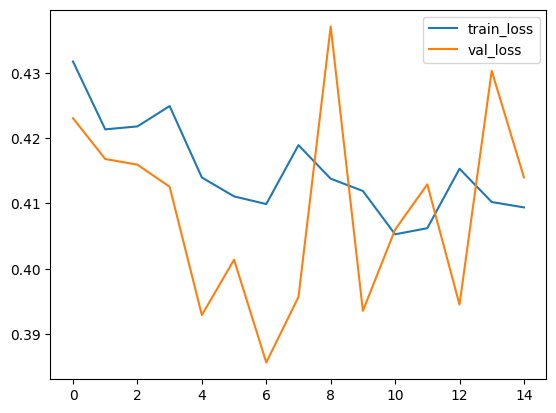

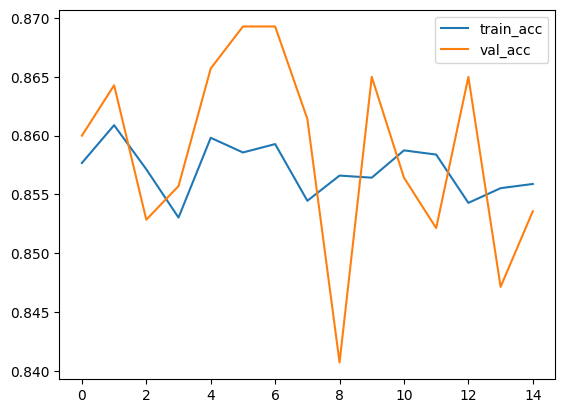

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [ ]:
model.evaluate(val_ds)


700/700 ━━━━━━━━━━━━━━━━━━━━ 168s 239ms/step - accuracy: 0.8541 - loss: 0.4136


[0.3902859389781952, 0.8671428561210632]

In [ ]:
# Colab cell 7 - evaluate and save
loss, acc = model.evaluate(val_ds)
print(f'Validation loss: {loss:.4f}, accuracy: {acc:.4f}')

# final save
final_path = '/content/drive/MyDrive/npz_model_checkpoints/final_model.h5'
model.save(final_path)
print('Saved model to', final_path)


700/700 ━━━━━━━━━━━━━━━━━━━━ 164s 234ms/step - accuracy: 0.8512 - loss: 0.4176


Validation loss: 0.4210, accuracy: 0.8500
Saved model to /content/drive/MyDrive/npz_model_checkpoints/final_model.h5
